# **COVID-19 Chest X-Ray Classification Using Convolutional Neural Networks**

This notebook presents a complete deep-learning pipeline for binary classification of chest X-ray images into **NORMAL** and **PNEUMONIA** categories (COVID-19–related or non-COVID pneumonia, depending on dataset definition). The workflow includes data preprocessing, CNN model development, training, evaluation, and sample predictions.

The primary objectives of this project are:

- To develop a baseline convolutional neural network for chest X-ray image classification.
- To evaluate model performance using standard metrics such as accuracy, loss, confusion matrix, and classification report.
- To demonstrate a function-based, modular deep learning workflow that can be extended to more complex architectures.

This notebook is intended for academic and exploratory research purposes, not for clinical diagnostic use.


In [1]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Dense, Dropout, MaxPool2D, Flatten, Input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix

In [2]:
# Suppress unnecessary warnings to keep the output clean
import warnings
warnings.filterwarnings('ignore')

In [3]:
# Set seeds to ensure reproducibility across runs
np.random.seed(42)
tf.random.set_seed(42)

## **1. Data Preprocessing**

Before training the model, the dataset must be prepared to ensure consistent input size, proper normalization, and augmentation to reduce overfitting.

This section implements the following steps:

- **Directory-based data loading** using `ImageDataGenerator`.
- **Image scaling** to normalize pixel values.
- **Data augmentation** (shear, zoom, horizontal flips) to improve generalization.
- **Automatic label extraction** from directory names.
- **Train/test batch generation** with a specified target image size.

The `data_preprocessor()` function encapsulates all preprocessing logic, making it reusable for future experiments.


In [4]:
def data_preprocessor(path, target_size, batch_size=32):
    """
    Preprocesses image data from a directory for training and testing.

    Args:
        path (str): Path to the dataset directory. Must contain 'train' and 'test' subdirectories.
        target_size (tuple): Desired image size in the format (height, width).
        batch_size (int): Number of samples per generated batch.

    Returns:
        tuple: (train_data, test_data) where both are DirectoryIterator objects
               that yield augmented and normalized image batches.
    """
    
    # Create image generators with scaling and augmentation
    train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
    )
    
    test_datagen = ImageDataGenerator(rescale = 1./255)
    
    # Read train images from directory structure
    train = train_datagen.flow_from_directory(
    path + 'train',
    target_size=target_size,
    batch_size=batch_size,
    class_mode='binary'
    )
    
    # Read test images without augmentation
    test = test_datagen.flow_from_directory(
    path + 'test',
    target_size=target_size,
    batch_size=batch_size,
    class_mode='binary'
    )

    return train, test

In [5]:
folder_path = 'xray_dataset_covid19/'

train, test = data_preprocessor(path=folder_path, target_size=(224, 224))

Found 148 images belonging to 2 classes.
Found 40 images belonging to 2 classes.


## **2. Model Architecture**

The model used in this experiment is a custom Convolutional Neural Network (CNN) built using the Keras Sequential API. The architecture includes:

- Convolutional layers for feature extraction  
- MaxPooling layers to reduce spatial dimensions  
- Dropout for regularization  
- Dense layers for final classification  

This CNN serves as a simple, interpretable baseline model for chest X-ray image classification. The modular design allows easy experimentation with deeper or more complex architectures.


In [6]:
def build_model(input_shape):
    """
    Builds and compiles a baseline CNN for binary image classification.

    Args:
        input_shape (tuple): Shape of the input images (height, width, channels).

    Returns:
        tensorflow.keras.Model: A compiled CNN model ready for training.
    """
    
    model = Sequential()
    model.add(Input(shape=input_shape))

    # Convolutional block 1
    model.add(Conv2D(filters=64, kernel_size=3, activation='relu'))
    model.add(MaxPool2D(pool_size=2, strides=2))
    model.add(Dropout(0.3)) # Reduce overfitting

    # Convolutional block 2
    model.add(Conv2D(filters=128, kernel_size=3, activation='relu'))
    model.add(MaxPool2D(pool_size=2, strides=2))
    model.add(Dropout(0.3)) # Reduce overfitting

    # Convolutional block 3
    model.add(Conv2D(filters=256, kernel_size=3, activation='relu'))
    model.add(MaxPool2D(pool_size=2, strides=2))
    model.add(Dropout(0.3)) # Reduce overfitting

    # Flatten feature maps into a vector
    model.add(Flatten())

    # Fully connected classifier
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.3)) # Reduce overfitting

    # Output layer (binary classification)
    model.add(Dense(1, activation='sigmoid'))

    # Compile model with optimizer and loss function
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    
    return model

In [7]:
model = build_model(input_shape=(224, 224, 3))

### Model Summary

The following summary outlines the architectural components, layer types, parameter counts, and connectivity of the CNN model used in this study.

In [8]:
# Display the structure and parameters of the CNN model
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 222, 222, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 111, 111, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 111, 111, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 109, 109, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 54, 54, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 54, 54, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 52, 52, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 26, 26, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 26, 26, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 173056)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │      22,151,296 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 22,522,241 (85.92 MB)

 Trainable params: 22,522,241 (85.92 MB)

 Non-trainable params: 0 (0.00 B)

## **3. Model Training**

The model is trained on the preprocessed training dataset using the Adam optimizer and binary cross-entropy loss. During training, both **accuracy** and **loss** are monitored for the training and validation sets.

Training details include:

- **Number of epochs:** 25  
- **Batch size:** inherited from the data generator  
- **Real-time data augmentation:** improves robustness  
- **Validation monitoring:** prevents overfitting  

The training history captured here will later be visualized to analyze model behavior.


In [9]:
# Train the CNN on the training dataset while validating on the test set
history = model.fit(train, validation_data=test, epochs=25)

Epoch 1/25
5/5 ━━━━━━━━━━━━━━━━━━━━ 17s 3s/step - accuracy: 0.4595 - loss: 3.8453 - val_accuracy: 0.5000 - val_loss: 0.6921
Epoch 2/25
5/5 ━━━━━━━━━━━━━━━━━━━━ 11s 2s/step - accuracy: 0.4865 - loss: 0.6956 - val_accuracy: 0.9500 - val_loss: 0.6858
Epoch 3/25
5/5 ━━━━━━━━━━━━━━━━━━━━ 12s 2s/step - accuracy: 0.5676 - loss: 0.6832 - val_accuracy: 0.5750 - val_loss: 0.6618
Epoch 4/25
5/5 ━━━━━━━━━━━━━━━━━━━━ 14s 3s/step - accuracy: 0.6824 - loss: 0.6186 - val_accuracy: 0.9750 - val_loss: 0.5468
Epoch 5/25
5/5 ━━━━━━━━━━━━━━━━━━━━ 13s 3s/step - accuracy: 0.7365 - loss: 0.5320 - val_accuracy: 0.9750 - val_loss: 0.3227
Epoch 6/25
5/5 ━━━━━━━━━━━━━━━━━━━━ 13s 3s/step - accuracy: 0.8041 - loss: 0.4876 - val_accuracy: 0.8250 - val_loss: 0.3614
Epoch 7/25
5/5 ━━━━━━━━━━━━━━━━━━━━ 12s 2s/step - accuracy: 0.7973 - loss: 0.4430 - val_accuracy: 0.9750 - val_loss: 0.2273
Epoch 8/25
5/5 ━━━━━━━━━━━━━━━━━━━━ 16s 3s/step - accuracy: 0.7770 - loss: 0.4933 - val_accuracy: 0.9750 - val_loss: 0.2591
Epoch 9/

In [10]:
# Save trained model weights
model.save('covid19_xray_cnn.h5')

## **4. Model Evaluation**

After training, the model is evaluated on the test dataset to assess its generalization performance. Evaluation metrics include:

- Test accuracy  
- Test loss  
- Classification report (precision, recall, F1-score)  
- Confusion matrix and heatmap  

These metrics provide insights into class-wise performance and potential failure patterns.


In [11]:
# Evaluate the model on the test dataset
# Outputs test loss and test accuracy
model.evaluate(test)

2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 408ms/step - accuracy: 0.9750 - loss: 0.1199


[0.11987966299057007, 0.9750000238418579]

In [12]:
# Extract true labels from test generator
true_label = test.classes

# Predict probabilities for each image in the test set
prediction = model.predict(test)

# Convert probabilities into binary class predictions
model_pred = []
for i in prediction:
    if i > 0.5:
        i = 1
        model_pred.append(i)
    else:
        i = 0
        model_pred.append(i)

2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 461ms/step


In [13]:
# Compute confusion matrix based on true vs predicted labels
cm = confusion_matrix(true_label, model_pred)
print(cm)
print('\n')

# Display precision, recall, and F1-score for each class
print(classification_report(true_label, model_pred))

[[ 9 11]
 [12  8]]


              precision    recall  f1-score   support

           0       0.43      0.45      0.44        20
           1       0.42      0.40      0.41        20

    accuracy                           0.42        40
   macro avg       0.42      0.43      0.42        40
weighted avg       0.42      0.42      0.42        40



### Confusion Matrix Visualization

The confusion matrix visualizes the distribution of correct and incorrect predictions across the two classes. This helps identify:

- Class imbalance effects  
- Misclassification tendencies  
- Model bias toward a particular class  

Darker diagonal values indicate stronger performance.


<Axes: >

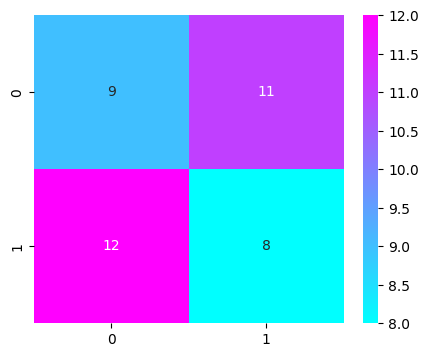

In [14]:
# Plot the confusion matrix as a heatmap for easier visual interpretation
plt.figure(figsize=(5, 4))
sns.heatmap(cm, cmap='cool', annot=True)

## **5. Sample Predictions**

In this section, the trained CNN model is used to generate predictions on unseen X-ray images from the test dataset. The predicted label is compared with the true label to illustrate model behavior.

This step demonstrates:

- How to use the trained model for inference  
- How predictions are mapped from probability outputs to class labels  
- Example visualizations of model decisions (optional addition)


In [15]:
# View the mapping of class labels to their corresponding numeric indices
train.class_indices

{'NORMAL': 0, 'PNEUMONIA': 1}

In [16]:
# Define a function to preprocess an image and make a prediction using the trained model
def model_predict(img, actual):
        """
    Preprocesses an input image, generates a prediction using the trained model, 
    and displays the result alongside the actual label.

    Args:
        img (PIL.Image.Image): Input image resized to the model's expected dimensions.
        actual (str): Ground truth label for the image ('Normal' or 'Pneumonia').

    Returns:
        None: Shows the image with a title containing both actual and predicted labels.
    """

    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    result = model.predict(x)

    # Interpret the prediction result: 1 means 'Pneumonia', 0 means 'Normal'
    if result[0][0]== 1:
        pred = 'Pneumonia'
    else:
        pred = 'Normal'

    # Display the image with a title showing the actual and predicted labels
    plt.figure()
    plt.imshow(img)
    plt.title(f'Actual: {actual} | Predicted : {pred}')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 328ms/step


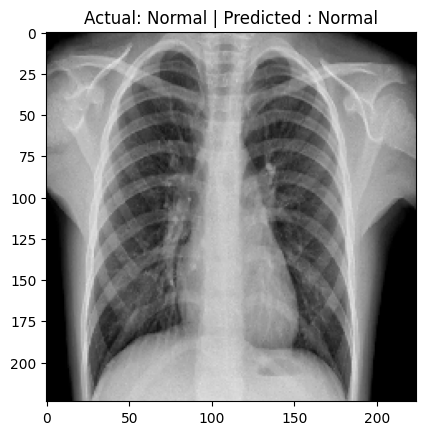

In [17]:
# Load a test image from the dataset and resize it to the model's input size
# Call the prediction function with the loaded image and its actual label
img = image.load_img('xray_dataset_covid19/single_prediction/normal.webp', target_size=(224, 224))
model_predict(img, 'Normal')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step


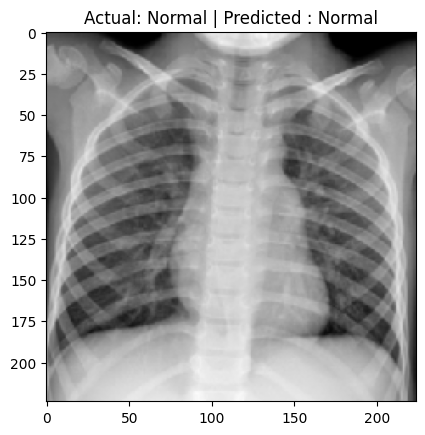

In [18]:
img2 = image.load_img('xray_dataset_covid19/single_prediction/normal2.png', target_size=(224, 224))
model_predict(img2, 'Normal')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step


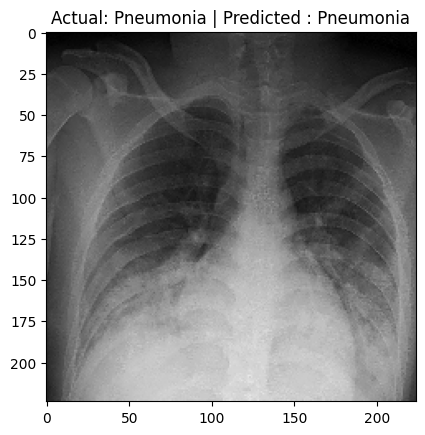

In [19]:
img3 = image.load_img('xray_dataset_covid19/single_prediction/pneumonia.jpeg', target_size=(224, 224))
model_predict(img3, 'Pneumonia')

## 6. **Training Performance Visualization**

To gain insight into the model’s learning dynamics, the training history is visualized through accuracy and loss curves for both the training and validation sets. These plots provide an essential diagnostic perspective to evaluate model behavior throughout the optimization process.

### **Interpretation Guidelines**
- **Accuracy Curves:**  
  Track how effectively the model learns distinguishing features.  
  A close alignment between training and validation accuracy generally indicates strong generalization capability.

- **Loss Curves:**  
  Show how well the model minimizes error on both datasets.  
  A steadily decreasing loss suggests successful learning, whereas divergence—particularly rising validation loss—may indicate overfitting.

- **Training vs. Validation Trends:**  
  - Parallel curves imply a stable training process.  
  - A widening gap with lower training loss but higher validation loss suggests overfitting.  
  - Flat or stagnant curves may indicate the need for architectural adjustments or learning-rate tuning.

### **Purpose of the Visualization**
These curves serve as an analytical tool to:
- Assess convergence behavior across epochs  
- Detect early signs of overfitting or underfitting  
- Evaluate the adequacy of the model architecture and hyperparameters  
- Guide future improvements such as regularization, data augmentation, or model complexity adjustments

The following plots illustrate the model’s accuracy and loss progression across all training epochs.


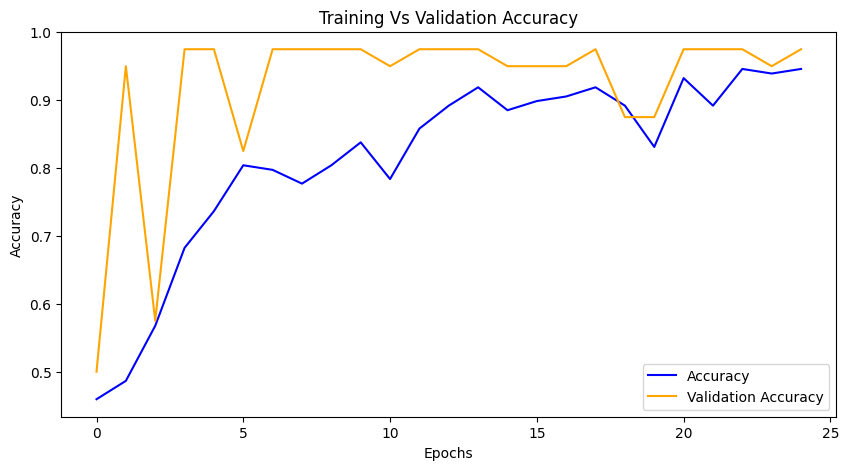

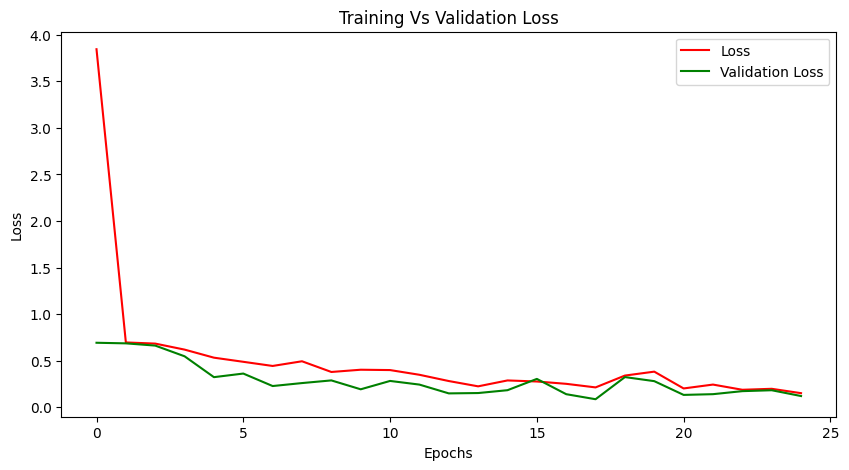

In [20]:
# Plot training and validation accuracy and loss to visualize learning behavior

# ---- Accuracy curve ----
plt.figure(figsize=(10, 5))
plt.plot(history.history['accuracy'], label='Accuracy', color='blue')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', color='orange')
plt.title('Training Vs Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# ---- Loss curve ----
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Loss', color='red')
plt.plot(history.history['val_loss'], label='Validation Loss', color='green')
plt.title('Training Vs Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

## **7. Conclusion**

This project presented a complete deep-learning pipeline for binary classification of chest X-ray images using a custom Convolutional Neural Network (CNN). The workflow included data preprocessing, model construction, training, evaluation, and inference on unseen images.

### **Key Outcomes**
- The CNN successfully learned distinguishable radiographic patterns between NORMAL and PNEUMONIA classes.
- Training and validation accuracy/loss curves demonstrated the model’s learning progression and highlighted areas for potential optimization.
- Evaluation metrics such as precision, recall, F1-score, and the confusion matrix provided detailed insights into class-wise performance.
- The model was able to correctly classify several unseen images, validating its ability to generalize beyond the training set.

### **Limitations**
- The model architecture is intentionally simple and may not capture subtle clinical features present in X-ray images.
- The dataset size and class distribution can significantly impact generalization performance.
- The model is trained on publicly available datasets, which may not reflect the full diversity of real-world clinical imaging.

### **Future Work**
To further improve performance and robustness:
- Experiment with deeper architectures (e.g., VGG16, ResNet50, EfficientNet).
- Apply advanced augmentation (CLAHE, rotation, brightness randomization).
- Introduce regularization techniques (L2, dropout tuning, early stopping).
- Use Grad-CAM or saliency maps for model interpretability.
- Expand the dataset to include multiple types of pneumonia and more demographic diversity.

This notebook serves as a strong baseline implementation and a foundational framework for future experimentation in medical image classification workflows.
